# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
import rasterio
import geopandas as gpd

# Determine the Temporal Pattern at each rain guage

Each rain guage will experience a different temporal pattern, as the rainfall moves accross the city. We can determine the shape of this pattern by looking at the hourly rainfall recorded by the [GSMaP data](https://sharaku.eorc.jaxa.jp/GSMaP/) provided by Japan Aerospace Exploration Agency (JAXA). This data has been downloaded for each of the rainguages.


In [2]:
import os
os.getcwd()


'/home/ubuntu/uae_hydrology/notebooks'

In [3]:
skip_header_rows = list(range(1, 6))
satellite_df = pd.read_csv('../input_data/gsmap_rainfall.csv', index_col=0, skiprows=skip_header_rows, header=0)
satellite_df.index = pd.to_datetime(satellite_df.index)
satellite_df.head()

,Um Azimul,Gasyoura,Hamim,Mezaira,Mukhariz,Al Jazeera b.g,Owtaid,Bada Dafas,Madinat Zayed,Bu Humrah,...,Al Qattara,Raknah,Buraimi,Um ghafa,Mezyed,Al Khazna,Al Arad,Al Shuaibah,Hafeet mountain,Barakah 2
name,,,,,,,,,,,,,,,,,,,,,
2024-04-14 00:00:00,0.0000,0.0389,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0568,...,0.0,0.0,0.0164,0.1317,0.0644,0.0,0.0145,0.0496,0.3047,0.0
2024-04-14 01:00:00,0.0462,0.0791,0.0,1.6735,0.0,0.0,0.0,0.0,0.0,0.6274,...,0.0,0.0,0.0000,0.2993,0.2589,0.0,0.7846,0.0000,0.2159,0.0
2024-04-14 02:00:00,0.1150,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.8540,0.0000,0.0000,0.0
2024-04-14 03:00:00,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0
2024-04-14 04:00:00,0.0000,0.0000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0


<Figure size 640x480 with 0 Axes>

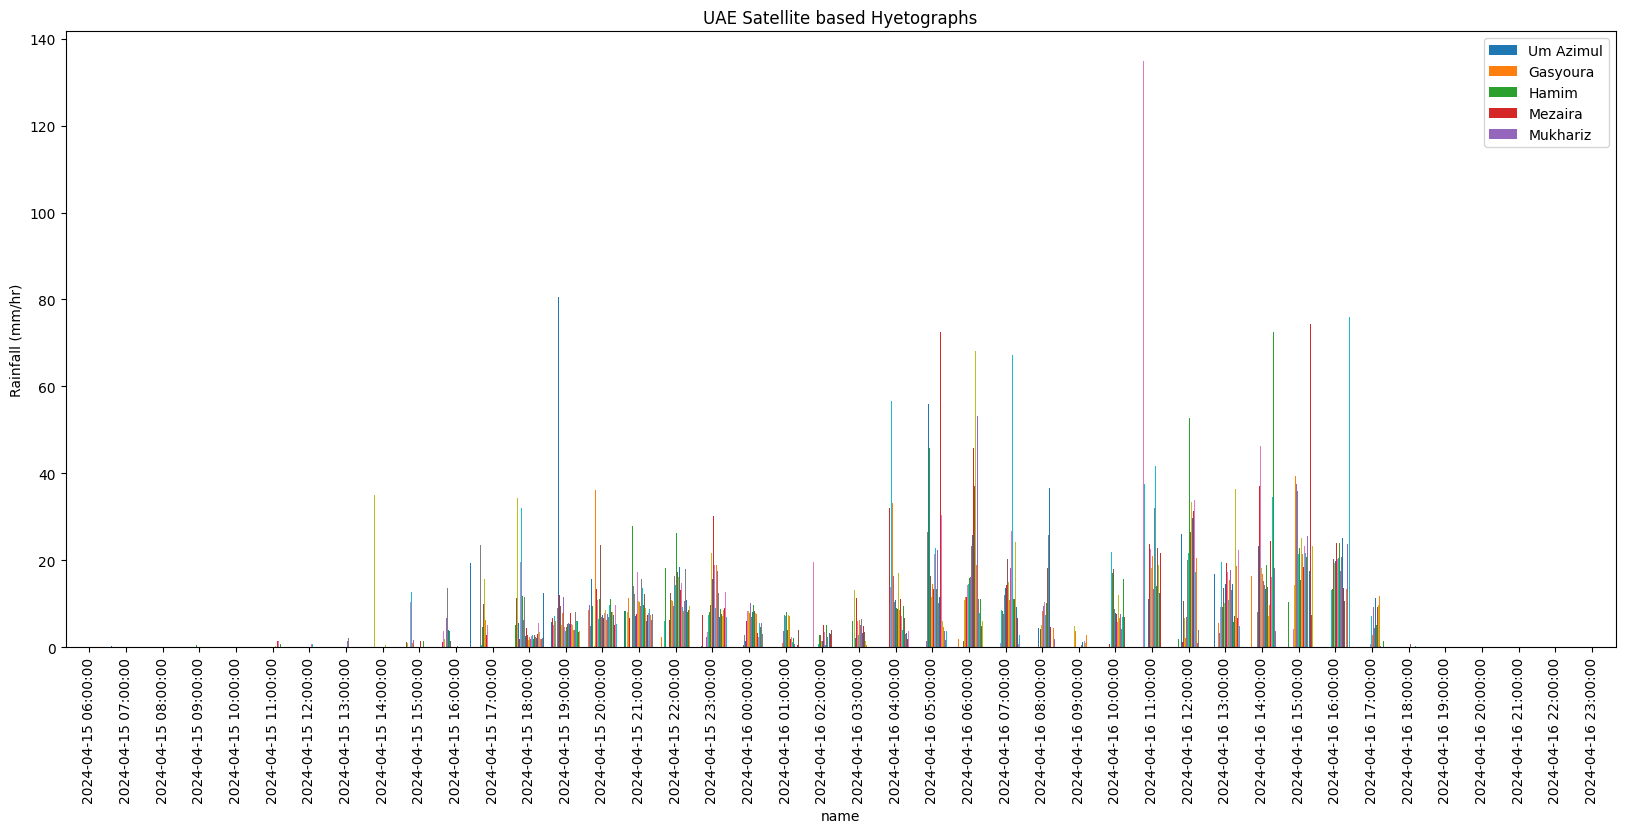

In [4]:
plt.figure()
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title('UAE Satellite based Hyetographs')
ax.set_xlabel('Datetime')
ax.set_ylabel('Rainfall (mm/hr)')

start_datestring = '2024-04-15 06:00:00'
end_datestring = '2024-04-16 23:00:00'
location_names_to_plot = satellite_df.columns

df_time_window = satellite_df.loc[start_datestring:end_datestring]
df_time_window.plot(kind='bar', ax=ax, width=0.8)

legend_labels = satellite_df.columns[:5]
plt.legend(legend_labels)
plt.show()


# Adjust the satellite data to match the ground-based raingauge data.

Now we have two independent data sources at each rainguage:
1. The total cumulative rainfall measured at each rainguage (sourced from the UAE NCM)
2. The estimated rainfall timeseries from the GSMaP data. This is less reliable for the volume of rainfall, but has an hourly temporal resolution. 

First we compare the ground-based volume with the satellite-based volume, and determine a calibration ratio that should be applied to the satellite time-series data to ensure it now matches the ground-based volume.

In [5]:
cumulative_satellite_rainfall = satellite_df.sum(axis=0)
cumulative_satellite_rainfall.name='cumulative_satellite_rainfall'
cumulative_satellite_rainfall

Um Azimul           43.6881
Gasyoura            33.0349
Hamim               36.5380
Mezaira             36.8603
Mukhariz            18.6905
                     ...   
Al Khazna          129.3765
Al Arad             93.0785
Al Shuaibah        145.9971
Hafeet mountain    172.6091
Barakah 2          102.1311
Name: cumulative_satellite_rainfall, Length: 81, dtype: float64

In [6]:
metadata_df = pd.read_csv('../input_data/gsmap_rainfall.csv', nrows=4, index_col=0).T
metadata_df['cumulative_satellite_rainfall'] = cumulative_satellite_rainfall
metadata_df['satellite_rainfall_adjustment_factor'] = (metadata_df['cumulative_rainfall_14_to_17_april_2024'] / metadata_df['cumulative_satellite_rainfall'])
metadata_df


name,ncm_id,longitude,latitude,cumulative_rainfall_14_to_17_april_2024,cumulative_satellite_rainfall,satellite_rainfall_adjustment_factor
Um Azimul,16.0,55.133333,22.700000,13.4,43.6881,0.306720
Gasyoura,137.0,54.816667,22.816667,47.2,33.0349,1.428792
Hamim,17.0,54.300000,22.966667,43.9,36.5380,1.201489
Mezaira,114.0,53.833333,23.116667,85.8,36.8603,2.327708
Mukhariz,24.0,52.883333,22.900000,13.9,18.6905,0.743693
...,...,...,...,...,...,...
Al Khazna,6.0,55.100000,24.150000,162.9,129.3765,1.259116
Al Arad,14.0,55.516667,23.833333,107.9,93.0785,1.159237
Al Shuaibah,412.0,55.600000,24.100000,176.2,145.9971,1.206873
Hafeet mountain,421.0,55.766667,24.050000,57.9,172.6091,0.335440


In [7]:
metadata_df['satellite_rainfall_adjustment_factor'].describe()

count    77.000000
mean      0.616353
std       0.527316
min       0.019139
25%       0.306720
50%       0.523442
75%       0.774310
max       3.790504
Name: satellite_rainfall_adjustment_factor, dtype: float64

In [8]:
ground_df = satellite_df * metadata_df['satellite_rainfall_adjustment_factor']
ground_df

,Um Azimul,Gasyoura,Hamim,Mezaira,Mukhariz,Al Jazeera b.g,Owtaid,Bada Dafas,Madinat Zayed,Bu Humrah,...,Al Qattara,Raknah,Buraimi,Um ghafa,Mezyed,Al Khazna,Al Arad,Al Shuaibah,Hafeet mountain,Barakah 2
name,,,,,,,,,,,,,,,,,,,,,
2024-04-14 00:00:00,0.000000,0.055580,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.068874,...,0.0,0.0,NaN,0.087949,0.048256,0.0,0.016809,0.059861,0.102209,0.0
2024-04-14 01:00:00,0.014170,0.113017,0.0,3.895419,0.0,0.0,0.0,0.0,0.0,0.760765,...,0.0,0.0,NaN,0.199873,0.193997,0.0,0.909537,0.000000,0.072422,0.0
2024-04-14 02:00:00,0.035273,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,NaN,0.000000,0.000000,0.0,0.989988,0.000000,0.000000,0.0
2024-04-14 03:00:00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2024-04-14 04:00:00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-17 20:00:00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2024-04-17 21:00:00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
2024-04-17 22:00:00,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,NaN,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


<Figure size 640x480 with 0 Axes>

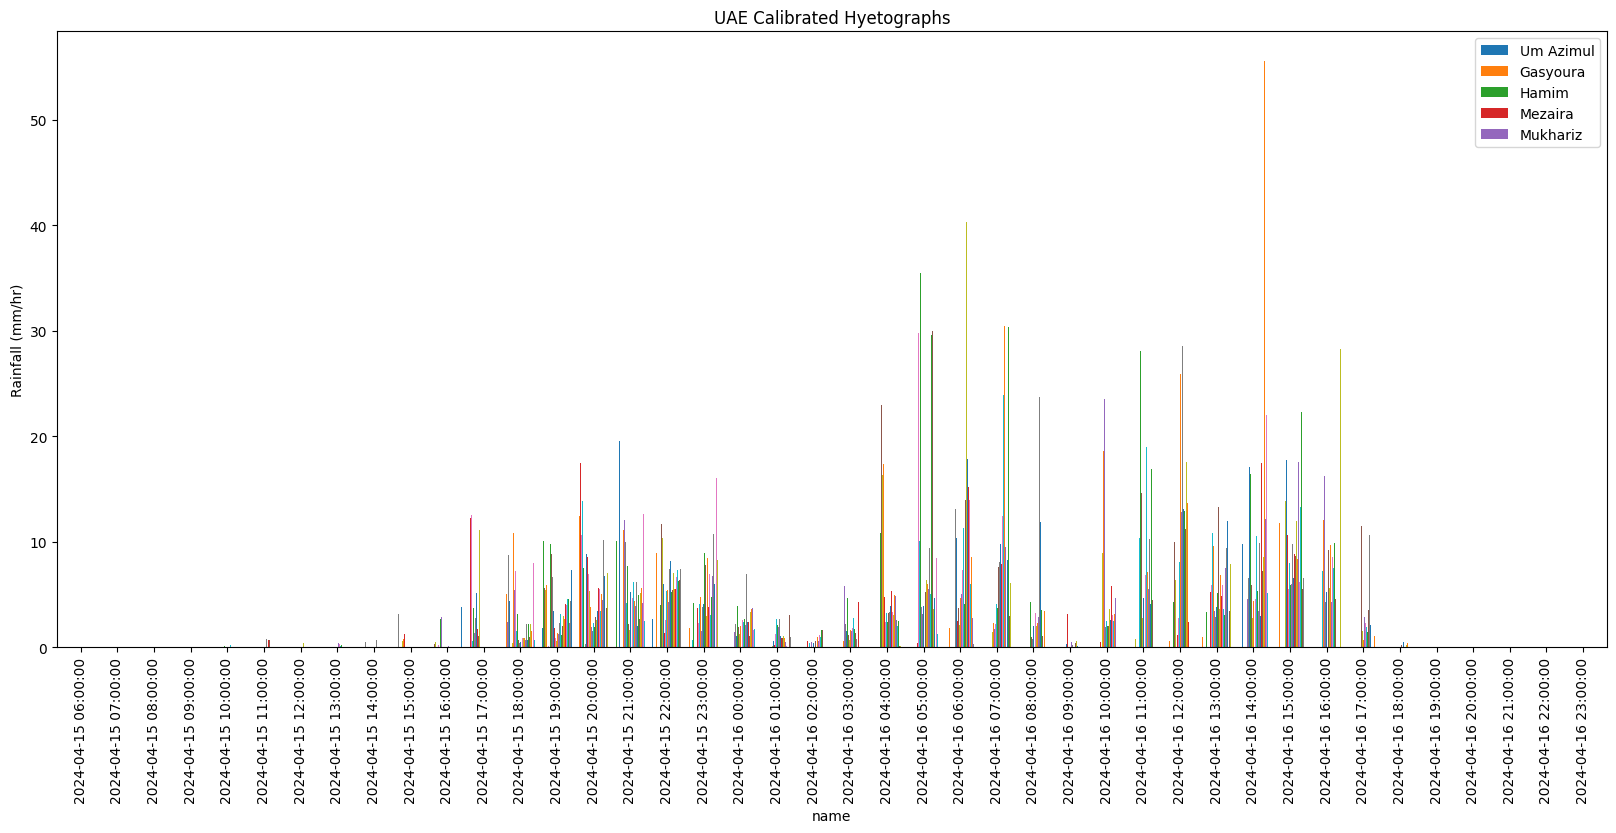

In [9]:
plt.close()
ground_df.head()
plt.figure()
fig_2, ax = plt.subplots(figsize=(20, 8))
ax.set_title('UAE Calibrated Hyetographs')
ax.set_xlabel('Datetime')
ax.set_ylabel('Rainfall (mm/hr)')
location_names_to_plot_2 = ground_df.columns

df_time_window = ground_df.loc[start_datestring:end_datestring]
df_time_window.plot(kind='bar', ax=ax, width=0.8)

legend_labels = ground_df.columns[:5]
plt.legend(legend_labels)


# Convert to UTM Zone 40 and export a shapefile with the calibrated timeseries at each raingauge

In [10]:
metadata_gdf = gpd.GeoDataFrame(metadata_df, geometry=gpd.points_from_xy(metadata_df['longitude'], metadata_df['latitude']), crs='EPSG:4326')
metadata_gdf = metadata_gdf.to_crs('EPSG:32640')
ground_dft = ground_df.T
ground_dft.columns = ground_dft.columns.map(str)
metadata_gdf = pd.concat([metadata_gdf, ground_dft], axis=1)
metadata_gdf.to_file("ncm_stations.json", driver='GeoJSON')
ground_dft
metadata_gdf

name,ncm_id,longitude,latitude,cumulative_rainfall_14_to_17_april_2024,cumulative_satellite_rainfall,satellite_rainfall_adjustment_factor,geometry,2024-04-14 00:00:00,2024-04-14 01:00:00,2024-04-14 02:00:00,...,2024-04-17 15:00:00,2024-04-17 16:00:00,2024-04-17 17:00:00,2024-04-17 18:00:00,2024-04-17 19:00:00,2024-04-17 20:00:00,2024-04-17 21:00:00,2024-04-17 22:00:00,2024-04-17 23:00:00,2024-04-18 00:00:00
Um Azimul,16.0,55.133333,22.700000,13.4,43.6881,0.306720,POINT (308257.029 2511516.124),0.000000,0.014170,0.035273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gasyoura,137.0,54.816667,22.816667,47.2,33.0349,1.428792,POINT (275909.446 2524881.295),0.055580,0.113017,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hamim,17.0,54.300000,22.966667,43.9,36.5380,1.201489,POINT (223160.228 2542376.268),0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mezaira,114.0,53.833333,23.116667,85.8,36.8603,2.327708,POINT (175639.723 2559956.379),0.000000,3.895419,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mukhariz,24.0,52.883333,22.900000,13.9,18.6905,0.743693,POINT (77552.447 2538362.273),0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Al Khazna,6.0,55.100000,24.150000,162.9,129.3765,1.259116,POINT (306949.913 2672143.683),0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Al Arad,14.0,55.516667,23.833333,107.9,93.0785,1.159237,POINT (348923.463 2636564.758),0.016809,0.909537,0.989988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Al Shuaibah,412.0,55.600000,24.100000,176.2,145.9971,1.206873,POINT (357705.241 2666007.963),0.059861,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hafeet mountain,421.0,55.766667,24.050000,57.9,172.6091,0.335440,POINT (374598.344 2660312.35),0.102209,0.072422,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we interpolate the calibrated raingauge data and produce two outputs. 
1. An mp4 video file to check that things are working as we expect
2. A time series of geotiff files with the rainfall intensity in them

In [15]:
def make_hyetograph_for_one_location(location_name):
    label = location_name.replace(' ', '_').lower()
    plt.figure(figsize=(10, 6))
    fig_3, ax = plt.subplots(figsize=(20, 8))
    ax.set_title(location_name)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Rainfall (mm/hr)')
    data_raw = metadata_gdf.loc[location_name][7:][41:80]
    data_raw.plot(kind='bar')
    plt.subplots_adjust(bottom=0.3)
    plt.savefig(f'../output_data/rainfall/{label}_hyetograph.png')
    plt.show()
    data_raw.index = pd.to_datetime(data_raw.index)
    iso_index = data_raw.index.to_series().dt.strftime('%Y-%m-%dT%H:%M:%S')
    data_raw.index = iso_index
    data_raw.to_csv(f'../output_data/rainfall/{label}_raw.csv')
    data_5mm = (data_raw - 2)
    data_5mm.to_csv(f'../output_data/rainfall/{label}_2mm.csv')
    data_5mm = (data_raw - 5)
    data_5mm.to_csv(f'../output_data/rainfall/{label}_5mm.csv')


<Figure size 1000x600 with 0 Axes>

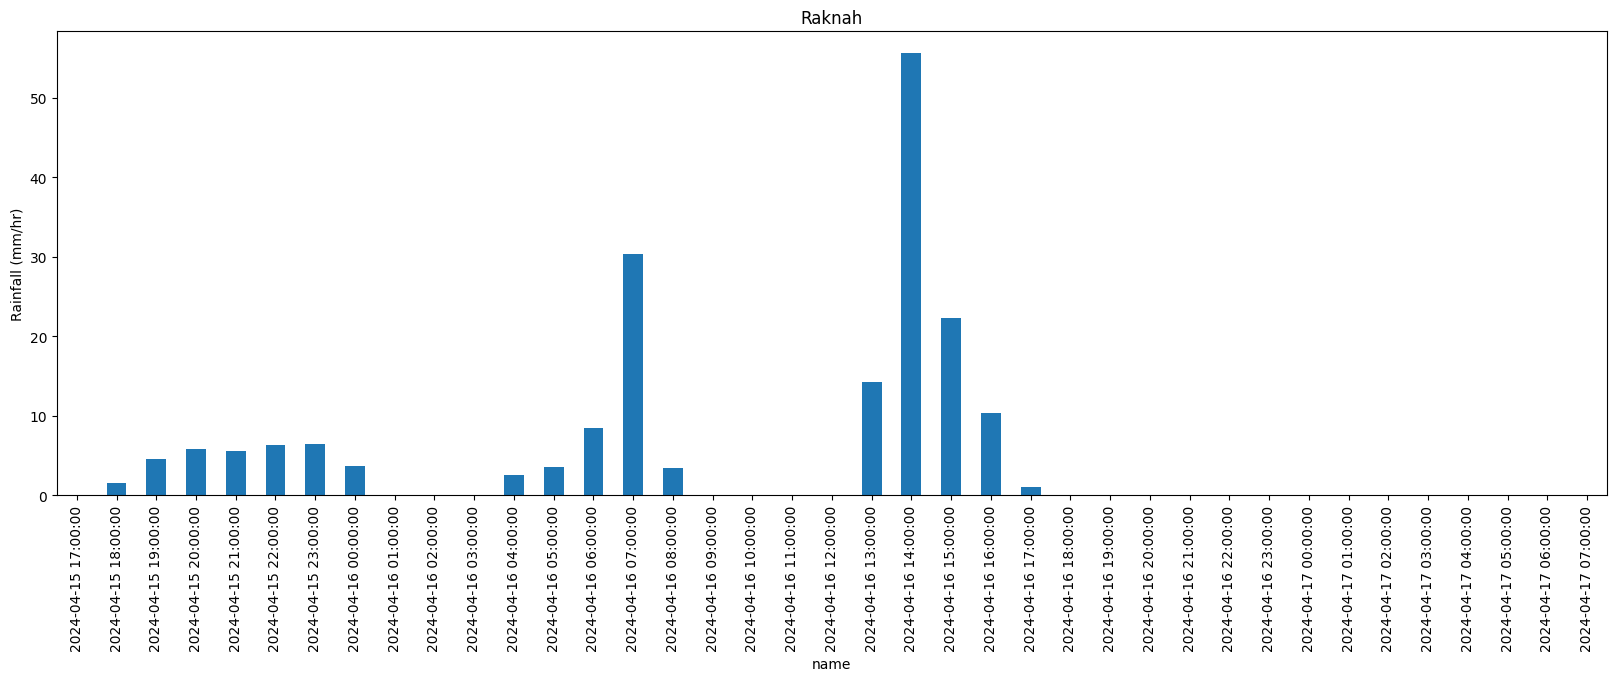

In [16]:
make_hyetograph_for_one_location('Raknah')

<Figure size 1000x600 with 0 Axes>

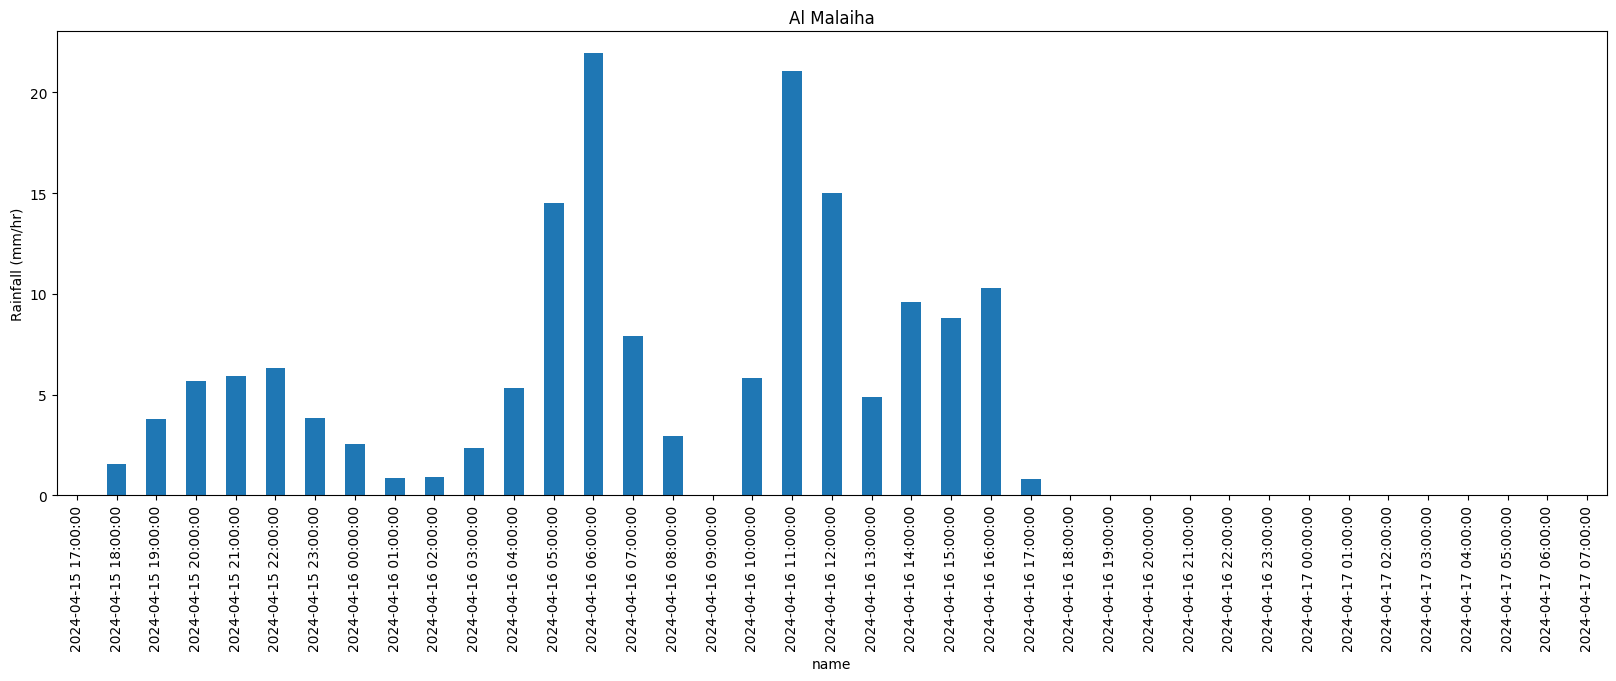

In [17]:
make_hyetograph_for_one_location('Al Malaiha')

In [14]:
start_datetime = pd.to_datetime('2024-04-15')
end_datetime = pd.to_datetime('2024-04-16')
total_hours = int(((end_datetime - start_datetime).total_seconds()) / 3600) + 1
coordinates = np.array(list(zip(metadata_gdf.geometry.x, metadata_gdf.geometry.y)))
values = metadata_gdf[start_datetime].values

min_x, min_y, max_x, max_y = metadata_gdf.geometry.total_bounds
grid_x, grid_y = np.mgrid[min_x:max_x:500j, min_y:max_y:500j]
grid_z = griddata(coordinates, values, (grid_x, grid_y), method='cubic')

transform = rasterio.transform.from_origin(grid_x[0][0], grid_y[-1][0], abs(grid_x[0][0] - grid_x[1][0]), abs(grid_y[0][0] - grid_y[0][1]))
geotiff = rasterio.open(
    'output.tif',
    'w',
    driver='GTiff',
    height=grid_z.shape[0],
    width=grid_z.shape[1],
    count=1,
    dtype=str(grid_z.dtype),
    crs=metadata_gdf.crs,
    transform=transform
)

geotiff.write(grid_z, 1)
geotiff.close()


KeyError: Timestamp('2024-04-15 00:00:00')